[ 0.1020309   9.7807951   0.91716141  0.02809921  0.01856671  6.7475667
 13.13326836  1.7397368   1.22453582]
[ 0.10868705 10.53203583  1.04954743  0.02904875  0.01864847 16.45280266
 17.16510963]

In [15]:
# Import libraries (requires jax and optax)
import matplotlib.pyplot as plt
import numpy as onp

from jax import numpy as np
from jax import random as jrandom
import jax.scipy.linalg as jla
import optax

from statsmodels.tsa import stattools

# Local functions
import nonstat_itides_jax as nsjax
from scipy.signal import welch


In [41]:
###
# Name of the parametric covariance function
covfunc=nsjax.itide_M2S2_meso_gammaexp

# True values of the covariance model parameters
eta_m2 = 0.03
eta_s2 = 0.02

tau_m2 = 7.0
tau_s2 = 13.0

gam_m2 = 1.75
gam_s2 = 1.2

eta_m = 0.0
tau_m = 10
gam_m = 0.9

cov_kwargs = {}


# Frequency bands for fitting
fmin = 1e-3 #0.7
fmax = 2.5 #

# Parameters for the time domain
dt = 1/24.
ndays = 180
###

covparams = (eta_m, tau_m, gam_m, eta_m2, eta_s2, tau_m2, tau_s2, gam_m2, gam_s2)

# Time in days
X = np.arange(0, ndays, dt)
N = X.shape[0]

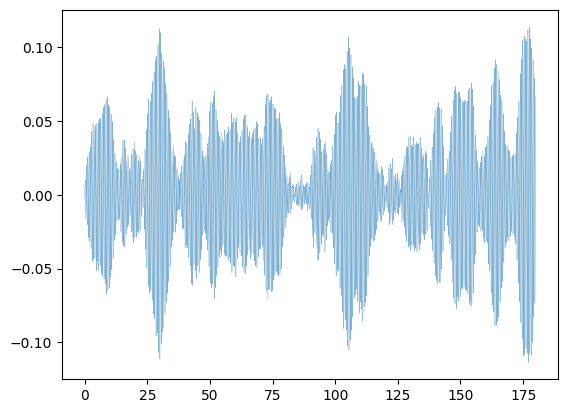

In [42]:
# Create a synthetic sample by drawing from a multivariate normal
K = covfunc(X[:,None], X[:,None].T, covparams)
L =  jla.cholesky(K, lower=True)

key = jrandom.PRNGKey(43)
myrand = jrandom.normal(key, shape=(N,)) 
        
y = L.dot(myrand) 
plt.plot(X,y, lw=0.2)

Text(0.5, 0, 'f [cpd]')

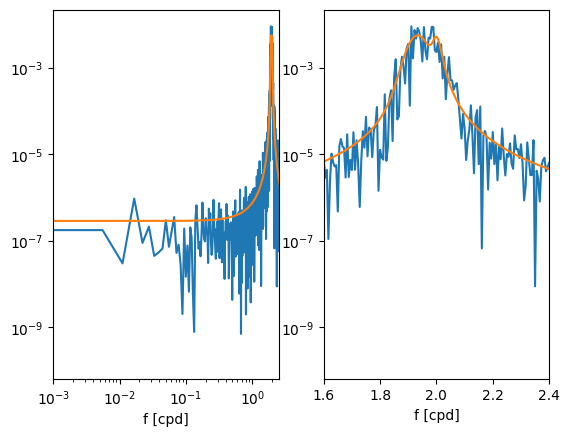

In [43]:
# Plot the periodogram of the time-series data and the parametric spectral profile
acf = covfunc(X, X[0], covparams, **cov_kwargs)
f, I = nsjax.periodogram(y, dt)
# bochner function does the discrete ifft
f_S, S = nsjax.bochner(acf, delta=dt)

fig, axs = plt.subplots(1,2)
ax=axs[0]
ax.loglog(f, I)
ax.loglog(f_S,S)
ax.set_xlim(fmin, fmax)
ax.set_xlabel('f [cpd]')

ax=axs[1]
ax.semilogy(f, I)
ax.semilogy(f_S,S)
ax.set_xlim(1.6, 2.4)
ax.set_xlabel('f [cpd]')


In [44]:
# Parameter estimation using jax
covparams_guess = (0.0, 10, 1.5, 0.05, 0.05, 5, 5, 1.5, 1.5)

params, loss_val = nsjax.estimate_jax(onp.array(y), onp.array(X), 
                      covfunc, covparams_guess,
                      fmin, fmax,
                      maxiter=1000,
                     opt= optax.adabelief(learning_rate=1e-1),
                     verbose=True)
print(72*'#')
print('Truth: ', covparams)
print('Estimated: ',params)
acf_gammaexp = covfunc(X, X[0], params, **cov_kwargs)

step 0, loss: -9374.4111328125
[ 0.        10.         1.5        0.0452419  0.0452419  5.525851
  5.525851   1.6577553  1.6577553]
step 25, loss: -10595.181640625
[ 0.         10.          1.5         0.02856706  0.02556996 10.880261
 15.092085    1.4897199   1.4410322 ]
step 50, loss: -10613.02734375
[ 0.         10.          1.5         0.0265922   0.02318438  7.8385015
 12.014933    1.6342324   1.447527  ]
step 75, loss: -10618.779296875
[ 0.         10.          1.5         0.02734738  0.02269831  6.6728544
  9.047156    1.7595071   1.475276  ]
step 91, loss: -10619.1806640625
########################################################################
Truth:  (0.0, 10, 0.9, 0.03, 0.02, 7.0, 13.0, 1.75, 1.2)
Estimated:  [ 0.         10.          1.5         0.02802432  0.02193656  6.7580366
  8.2925625   1.7753887   1.47612   ]


In [45]:
# Parameter estimation using jax
covparams_guess = (0.0, 10, 1.5, 0.05, 0.05, 5, 5,)
covfunc1 = nsjax.itide_M2S2_meso_gammaexp_fixed

params, loss_val = nsjax.estimate_jax(onp.array(y), onp.array(X), 
                      covfunc1, covparams_guess,
                      fmin, fmax,
                      maxiter=1000,
                     opt= optax.adabelief(learning_rate=1e-1),
                     verbose=True)
print(72*'#')
print('Truth: ', covparams)
print('Estimated: ',params)

acf_lorentzian = covfunc1(X, X[0], params, **cov_kwargs)

step 0, loss: -8256.8984375
[ 0.        10.         1.5        0.0452419  0.0452419  5.525851
  5.525851 ]
step 25, loss: -10318.498046875
[0.0000000e+00 1.0000000e+01 1.5000000e+00 2.0931125e-02 1.6829060e-02
 1.4423923e+01 1.7031261e+01]
step 50, loss: -10377.390625
[0.0000000e+00 1.0000000e+01 1.5000000e+00 1.9216947e-02 1.7024163e-02
 2.0692703e+01 2.0678204e+01]
step 75, loss: -10381.27734375
[0.0000000e+00 1.0000000e+01 1.5000000e+00 2.0660574e-02 1.7296469e-02
 2.3927206e+01 2.4398069e+01]
step 78, loss: -10381.2314453125
########################################################################
Truth:  (0.0, 10, 0.9, 0.03, 0.02, 7.0, 13.0, 1.75, 1.2)
Estimated:  [0.0000000e+00 1.0000000e+01 1.5000000e+00 2.0857487e-02 1.7494380e-02
 2.4240747e+01 2.4595999e+01]


(0.0, 336.0)

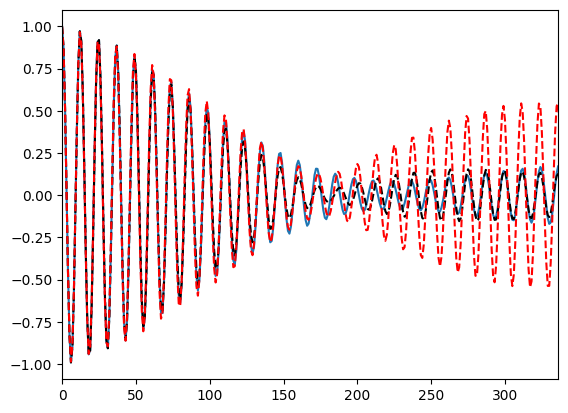

In [46]:
acf_est, ci = stattools.acf(y, nlags=14*24, alpha= 0.05, fft=False)

ax=plt.subplot(111)
ax.plot(acf_est)
ax.plot(acf/acf[0],'k--')
ax.plot(acf_lorentzian/acf_lorentzian[0],'r--')

ax.set_xlim(0, 14*24)

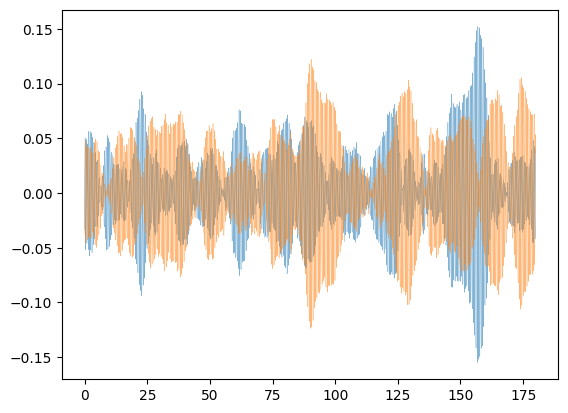

In [47]:
# Calculate the empirical ACF on a number of ensembles
nsamples = 50
key = jrandom.PRNGKey(42)
myrand = jrandom.normal(key, shape=(N,nsamples)) 
        
y_ens = L.dot(myrand) 
plt.plot(X,y_ens[:,0], lw=0.2)
plt.plot(X,y_ens[:,1], lw=0.2)

In [48]:
nlags = 14*24
acf_est = onp.zeros((nlags+1, nsamples))
for ii in range(nsamples):
    acf_est[:,ii], ci = stattools.acf(y_ens[:,ii], nlags=nlags, alpha= 0.05, fft=False, adjusted=True)

(0.0, 336.0)

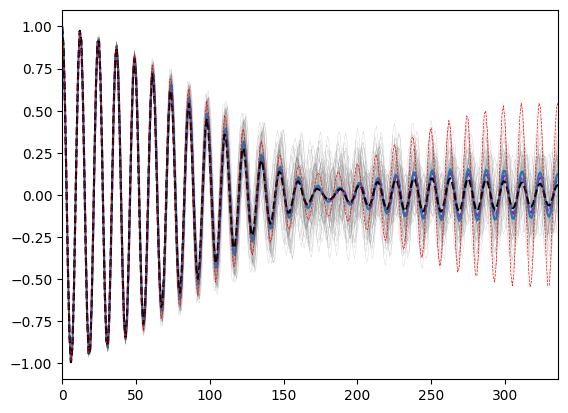

In [49]:

ax=plt.subplot(111)
for ii in range(nsamples):
    ax.plot(acf_est[:,ii], '0.5',lw=0.2, alpha=0.5)
ax.plot(acf_est.mean(axis=1), 'm--')
ax.plot(acf/acf[0])
ax.plot(acf_gammaexp/acf_gammaexp[0],'k--')
ax.plot(acf_lorentzian/acf_lorentzian[0],'r--', lw=0.5)
ax.set_xlim(0, nlags)

In [50]:
I_est = onp.zeros((N, nsamples))
for ii in range(nsamples):
    f, I_est[:,ii] = nsjax.periodogram(y_ens[:,ii], dt)

(1e-08, 0.1)

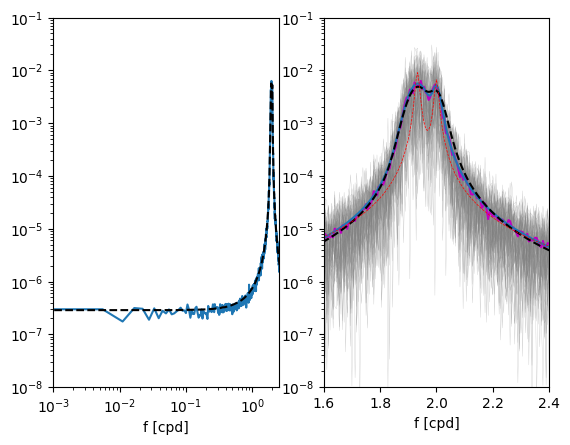

In [51]:
f_S, S_lorentzian = nsjax.bochner(acf_lorentzian, delta=dt)
f_S, S_gammaexp = nsjax.bochner(acf_gammaexp, delta=dt)

fig, axs = plt.subplots(1,2)
ax=axs[0]
ax.loglog(f, I_est.mean(axis=1))
ax.loglog(f_S,S, 'k--')
ax.set_xlim(fmin, fmax)
ax.set_xlabel('f [cpd]')
ax.set_ylim(1e-8, 1e-1)

ax=axs[1]
for ii in range(nsamples):
    ax.semilogy(f, I_est[:,ii], '0.5', lw=0.2, alpha=0.5)
ax.semilogy(f, I_est.mean(axis=1),'m')
# ax.semilogy(f, I, 'navy', lw=0.2, alpha=0.5)
ax.semilogy(f_S,S, )
ax.semilogy(f_S,S_gammaexp, 'k--')
ax.semilogy(f_S,S_lorentzian, 'r--', lw=0.5)

ax.set_xlim(1.6, 2.4)
ax.set_xlabel('f [cpd]')
ax.set_ylim(1e-8, 1e-1)

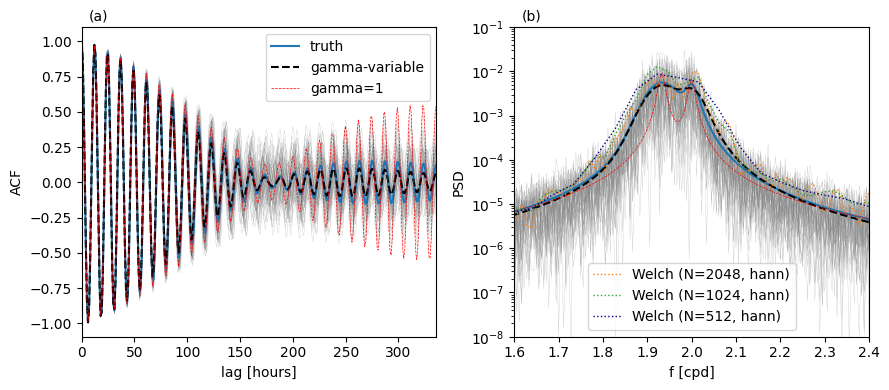

In [53]:
fig, axs = plt.subplots(1,2, figsize=(9,4))
ax=axs[0]
for ii in range(nsamples):
    ax.plot(acf_est[:,ii], '0.5',lw=0.2, alpha=0.5, )
# ax.plot(acf_est.mean(axis=1), 'm--', label=)
ax.plot(acf/acf[0], label='truth')
ax.plot(acf_gammaexp/acf_gammaexp[0],'k--', label='gamma-variable')
ax.plot(acf_lorentzian/acf_lorentzian[0],'r--', lw=0.5, label='gamma=1')
ax.set_xlim(0, nlags)
ax.set_xlabel('lag [hours]')
ax.set_ylabel('ACF')
ax.legend()
ax.text(0.02,1.02, '(a)', transform=ax.transAxes)


ax=axs[1]

for ii in range(nsamples):
    ax.semilogy(f, I_est[:,ii], '0.5', lw=0.2, alpha=0.5)
# ax.semilogy(f, I_est.mean(axis=1),'m')
# ax.semilogy(f, I, 'navy', lw=0.2, alpha=0.5)
ax.semilogy(f_S,S, )
ax.semilogy(f_S,S_gammaexp, 'k--')
ax.semilogy(f_S,S_lorentzian, 'r--', lw=0.5)

fw, Iw = welch(y_ens[:,0], 1/dt, nperseg=2048, window='hann')
ax.semilogy(fw, Iw, ':', lw=1., label='Welch (N=2048, hann)')

fw, Iw = welch(y_ens[:,0], 1/dt, nperseg=1024, window='hann')
ax.semilogy(fw, Iw, ':', lw=1., label='Welch (N=1024, hann)')

fw, Iw = welch(y_ens[:,0], 1/dt, nperseg=512, window='hann')
ax.semilogy(fw, Iw, ':',c='navy', lw=1., label='Welch (N=512, hann)')

# fw, Iw = welch(y_ens[:,0], 1/dt, nperseg=256, window='hann')
# ax.semilogy(fw, Iw, lw=1., label='Welch (N=256, hann)')

ax.legend()

ax.set_xlim(1.6, 2.4)
ax.set_xlabel('f [cpd]')
ax.set_ylim(1e-8, 1e-1)
ax.set_ylabel('PSD')
ax.text(0.02,1.02, '(b)', transform=ax.transAxes)
plt.tight_layout()

## Text for paper

### Synthetic time-series example
We demonstrate the robustness of our method by starting with a synthetic time-series example. We start out with an M2+S2 gamma-exponential ACF
$$
k_{\mathrm{IT}}(\tau) = \eta_{\mathrm{M2}}^2 \exp\left( - |\tau/\tau_{\mathrm{M2}}|^{\gamma_{\mathrm{M2}}} \right) \cos(\omega_{\mathrm{M2}} \tau) + \\
\eta_{\mathrm{S2}}^2 \exp\left( - |\tau/\tau_{\mathrm{S2}}|^{\gamma_{\mathrm{S2}}} \right) \cos(\omega_{\mathrm{S2}} \tau)
$$
to represent the non-phase-locked internal tide. We set the parameters $\theta=\lbrace \eta_{\mathrm{M2}}, \tau_{\mathrm{M2}}, \gamma_{\mathrm{M2}}, \eta_{\mathrm{S2}}, \tau_{\mathrm{S2}}, \gamma_{\mathrm{S2}}\rbrace = \lbrace  0.03,  7.0,  1.75,0.02,13.0, 1.2\rbrace$. We then took 50 samples from the multivariate normal (MVN) distribution with covariance $k_{\mathrm{IT}}(\tau)$ and plotted empirical estimates of both the ACF and PSD (FigXX). By drawing random samples from the MVN we can easily visualise the uncertainty in both the ACF and PSD. From the ACF, it is clear that the uncertainty grows with increasing lag (a well-known result). From the PSD, it is unclear whether there are two peaks. PSD estimates using Welch and different segment lengths (N) showed that the number of peaks and the spectral band-width were both dependent on this particular hyperparameter.

We estimated the non-phase-locked parameters using our debiased Whittle method using a variable- and fixed-gamma-exp model. We were able to recover the parameters within 10~\% using the same model used to generate the data. The fixed-gamma model (i.e., $\gamma_{\mathrm{M2}}=\gamma_{\mathrm{S2}}=1$) over-predicted the integral timescale in this case, as is evident from the overly-persistent ACF for lags greater than 7 d and overly narrow spectral peaks. 

The motivations here were to first demonstrate that both the empirical ACF and periodogram are noisy and difficult to directly infer timescales from through either parametric model fitting or spectral band-width estimation. The second motivation was to show that the Lorentzian-shaped ACF model will over-predict timescales in some instances (we also demonstrate this point further below with realistic examples). It is a bit of circular argument to claim here that the variable-gamma-exp model is superior, although we will demonstrate this point more thoroughly below. 